In [1]:
import pandas as pd
from trader_utils import BackTester, predictions_to_trades, get_xy
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
%matplotlib inline

Using TensorFlow backend.


In [15]:
class DeepLearningTrader:
    def __init__(self):
        self.n = 1
        self.rolling_window = 21
        self.ticker = None
        self.scaler = None

    def fit(self, ticker, start_date, end_date): 
        self.ticker = ticker
        train_x, train_y = get_xy(ticker, start_date, end_date, self.rolling_window, self.n)
        scaler = StandardScaler()
        scaler.fit(train_x)
        self.scaler = scaler
        train_x = scaler.transform(train_x)
        model = Sequential()
        model.add(Dense(64, input_dim=3, activation='relu'))
        for i in range(4):
            model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
        model.fit(train_x, train_y, epochs=500, verbose=1)
        self.model = model
    
    def generate_trades(self, start_date, end_date):
        test_x, _ = get_xy(self.ticker, start_date, end_date, self.rolling_window, self.n)
        test_x = self.scaler.transform(test_x)
        predictions = self.model.predict_classes(test_x)
        actual_start = self.rolling_window - 1
        trades = predictions_to_trades(self.ticker, predictions, start_date, end_date, self.n, actual_start)
        return trades

In [16]:
#initialize
dlt = DeepLearningTrader()

In [17]:
#define test cases

#test 1 case GOOG
in_sd = pd.datetime(2011,1,1)
in_ed = pd.datetime(2011,12,31)
out_sd = pd.datetime(2012,1,1)
out_ed = pd.datetime(2012,12,31)
ticker = 'GOOG'

# #test 2 case JPM
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'JPM'

# #test 3 case AMZN
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'AMZN'

# #test 4 case AAPL
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'AAPL'


In [18]:
#train model
dlt.fit(ticker, in_sd, in_ed)    

Epoch 1/500
231/231 [==============================] - 1s 3ms/step - loss: 0.6938 - acc: 0.4805
Epoch 2/500
231/231 [==============================] - 0s 74us/step - loss: 0.6880 - acc: 0.5325
Epoch 3/500
231/231 [==============================] - 0s 87us/step - loss: 0.6871 - acc: 0.5584
Epoch 4/500
231/231 [==============================] - 0s 74us/step - loss: 0.6852 - acc: 0.5584
Epoch 5/500
231/231 [==============================] - 0s 69us/step - loss: 0.6854 - acc: 0.5584
Epoch 6/500
231/231 [==============================] - 0s 82us/step - loss: 0.6822 - acc: 0.5758
Epoch 7/500
231/231 [==============================] - 0s 82us/step - loss: 0.6825 - acc: 0.5887
Epoch 8/500
231/231 [==============================] - 0s 78us/step - loss: 0.6817 - acc: 0.5801
Epoch 9/500
231/231 [==============================] - 0s 78us/step - loss: 0.6780 - acc: 0.5844
Epoch 10/500
231/231 [==============================] - 0s 82us/step - loss: 0.6790 - acc: 0.5714
Epoch 11/500
231/231 [========

231/231 [==============================] - 0s 78us/step - loss: 0.5097 - acc: 0.7056
Epoch 84/500
231/231 [==============================] - 0s 56us/step - loss: 0.5205 - acc: 0.7013
Epoch 85/500
231/231 [==============================] - 0s 65us/step - loss: 0.5058 - acc: 0.6970
Epoch 86/500
231/231 [==============================] - 0s 61us/step - loss: 0.5103 - acc: 0.7013
Epoch 87/500
231/231 [==============================] - 0s 69us/step - loss: 0.5067 - acc: 0.7056
Epoch 88/500
231/231 [==============================] - 0s 61us/step - loss: 0.5090 - acc: 0.7013
Epoch 89/500
231/231 [==============================] - 0s 65us/step - loss: 0.5254 - acc: 0.7100
Epoch 90/500
231/231 [==============================] - 0s 74us/step - loss: 0.5302 - acc: 0.7186
Epoch 91/500
231/231 [==============================] - 0s 65us/step - loss: 0.5405 - acc: 0.6710
Epoch 92/500
231/231 [==============================] - 0s 69us/step - loss: 0.5186 - acc: 0.7013
Epoch 93/500
231/231 [===========

231/231 [==============================] - 0s 56us/step - loss: 0.4387 - acc: 0.7749
Epoch 166/500
231/231 [==============================] - 0s 56us/step - loss: 0.4394 - acc: 0.7835
Epoch 167/500
231/231 [==============================] - 0s 52us/step - loss: 0.4387 - acc: 0.7835
Epoch 168/500
231/231 [==============================] - 0s 69us/step - loss: 0.4797 - acc: 0.7662
Epoch 169/500
231/231 [==============================] - 0s 52us/step - loss: 0.4936 - acc: 0.7619
Epoch 170/500
231/231 [==============================] - 0s 56us/step - loss: 0.4913 - acc: 0.7359
Epoch 171/500
231/231 [==============================] - 0s 56us/step - loss: 0.4406 - acc: 0.7662
Epoch 172/500
231/231 [==============================] - 0s 61us/step - loss: 0.4191 - acc: 0.7879
Epoch 173/500
231/231 [==============================] - 0s 56us/step - loss: 0.4227 - acc: 0.7835
Epoch 174/500
231/231 [==============================] - 0s 65us/step - loss: 0.4264 - acc: 0.7792
Epoch 175/500
231/231 [=

231/231 [==============================] - 0s 56us/step - loss: 0.3465 - acc: 0.8312
Epoch 248/500
231/231 [==============================] - 0s 61us/step - loss: 0.3840 - acc: 0.8009
Epoch 249/500
231/231 [==============================] - 0s 52us/step - loss: 0.4092 - acc: 0.8052
Epoch 250/500
231/231 [==============================] - 0s 69us/step - loss: 0.4256 - acc: 0.7792
Epoch 251/500
231/231 [==============================] - 0s 78us/step - loss: 0.4341 - acc: 0.7749
Epoch 252/500
231/231 [==============================] - 0s 61us/step - loss: 0.3822 - acc: 0.7922
Epoch 253/500
231/231 [==============================] - ETA: 0s - loss: 0.4170 - acc: 0.781 - 0s 65us/step - loss: 0.3676 - acc: 0.8182
Epoch 254/500
231/231 [==============================] - 0s 61us/step - loss: 0.3729 - acc: 0.8095
Epoch 255/500
231/231 [==============================] - 0s 65us/step - loss: 0.4027 - acc: 0.7965
Epoch 256/500
231/231 [==============================] - 0s 52us/step - loss: 0.3660 

231/231 [==============================] - 0s 82us/step - loss: 0.3037 - acc: 0.8701
Epoch 330/500
231/231 [==============================] - 0s 52us/step - loss: 0.3322 - acc: 0.8398
Epoch 331/500
231/231 [==============================] - 0s 52us/step - loss: 0.3237 - acc: 0.8571
Epoch 332/500
231/231 [==============================] - 0s 48us/step - loss: 0.3040 - acc: 0.8312
Epoch 333/500
231/231 [==============================] - 0s 56us/step - loss: 0.3232 - acc: 0.8485
Epoch 334/500
231/231 [==============================] - 0s 48us/step - loss: 0.3019 - acc: 0.8615
Epoch 335/500
231/231 [==============================] - 0s 56us/step - loss: 0.3284 - acc: 0.8268
Epoch 336/500
231/231 [==============================] - 0s 56us/step - loss: 0.3920 - acc: 0.8225
Epoch 337/500
231/231 [==============================] - 0s 61us/step - loss: 0.3572 - acc: 0.8139
Epoch 338/500
231/231 [==============================] - 0s 56us/step - loss: 0.3220 - acc: 0.8398
Epoch 339/500
231/231 [=

231/231 [==============================] - 0s 52us/step - loss: 0.2524 - acc: 0.8788
Epoch 412/500
231/231 [==============================] - 0s 52us/step - loss: 0.2787 - acc: 0.8788
Epoch 413/500
231/231 [==============================] - 0s 52us/step - loss: 0.2496 - acc: 0.8831
Epoch 414/500
231/231 [==============================] - 0s 56us/step - loss: 0.2486 - acc: 0.8831
Epoch 415/500
231/231 [==============================] - 0s 52us/step - loss: 0.2437 - acc: 0.8831
Epoch 416/500
231/231 [==============================] - 0s 56us/step - loss: 0.2411 - acc: 0.8831
Epoch 417/500
231/231 [==============================] - 0s 48us/step - loss: 0.2882 - acc: 0.8571
Epoch 418/500
231/231 [==============================] - 0s 48us/step - loss: 0.2853 - acc: 0.8615
Epoch 419/500
231/231 [==============================] - 0s 52us/step - loss: 0.2314 - acc: 0.8874
Epoch 420/500
231/231 [==============================] - 0s 48us/step - loss: 0.2417 - acc: 0.8918
Epoch 421/500
231/231 [=

231/231 [==============================] - 0s 48us/step - loss: 0.2614 - acc: 0.8961
Epoch 493/500
231/231 [==============================] - 0s 61us/step - loss: 0.2492 - acc: 0.8788
Epoch 494/500
231/231 [==============================] - 0s 56us/step - loss: 0.2664 - acc: 0.8831
Epoch 495/500
231/231 [==============================] - 0s 112us/step - loss: 0.2703 - acc: 0.8615
Epoch 496/500
231/231 [==============================] - 0s 112us/step - loss: 0.2507 - acc: 0.8788
Epoch 497/500
231/231 [==============================] - 0s 112us/step - loss: 0.2459 - acc: 0.8874
Epoch 498/500
231/231 [==============================] - 0s 108us/step - loss: 0.2369 - acc: 0.8961
Epoch 499/500
231/231 [==============================] - 0s 100us/step - loss: 0.2331 - acc: 0.8874
Epoch 500/500
231/231 [==============================] - 0s 95us/step - loss: 0.2344 - acc: 0.8874


In [19]:
#intialize backtester
starting_cash = 100000
holding_limit = 1000
btr = BackTester(starting_cash, holding_limit)

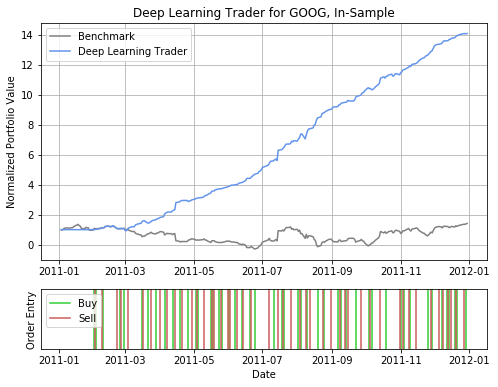

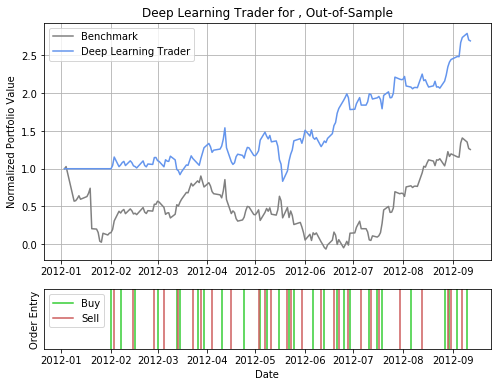

In [20]:
#generate trade in-sample
df_trades = dlt.generate_trades(in_sd, in_ed) 

plot_title = 'Deep Learning Trader for {}, In-Sample'.format(ticker)
algorithm_title = 'Deep Learning Trader'
btr.backtest(df_trades, plot_title, algorithm_title, benchmark=True, plot_size=(8,6))

#out-of-sample
start_date = pd.datetime(2012,1,1)
end_date = pd.datetime(2012,12,31)

#generate trade out-of-sample
df_trades = dlt.generate_trades(out_sd, out_ed) 
plot_title = 'Deep Learning Trader for , Out-of-Sample'.format(ticker)
algorithm_title = 'Deep Learning Trader'
btr.backtest(df_trades, plot_title, algorithm_title, benchmark=True, plot_size=(8,6)) 